<a href="https://colab.research.google.com/github/Parvez13/TensorFlow-Developer-Certification/blob/master/05_transfer_learning_in_tensorflow_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-tuning

In the previous notebook, we covered transfer learning feature extraction, now it's time to learn about a new kind of transfer learning: fine-tuning

In [ ]:
# Check if we're using a GPU
!nvidia-smi


Fri Jul 23 02:33:35 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a bunch of helper functions, now we could rewrite them all, however, this is tedious

So, it's a good idea to put functions you'll want to use again in a script you can download and import into your notebooks (or elsewhere).

In [ ]:


!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-07-23 02:33:36--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-23 02:33:36 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import hepler functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, walk_through_dir, unzip_data

> 🔑 **Note:** If you're running this notebook in Google Colab, when it times out Colab will delete `helper_functions.py`, so you'll have to redoenload it if you helper functions. 

## Let's get some data

This time we're going to see how we can use the pretrained models withing `tf.keras.applications` and apply them to our own problem (recognizing images of food).

link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [ ]:
# Get 10% of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-07-23 02:33:38--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.73.240, 142.250.65.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  80.6MB/s    in 2.0s    

2021-07-23 02:33:41 (80.6 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ch

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

In [ ]:
import tensorflow as tf

IMG_SIZE =(224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                             image_size=IMG_SIZE,
                                                             label_mode = 'categorical',
                                                             batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# Check out the classs names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
   print(images, labels)

tf.Tensor(
[[[[1.09438772e+01 9.94387722e+00 5.94387770e+00]
   [9.76020336e+00 8.76020336e+00 4.76020384e+00]
   [8.63775539e+00 7.63775492e+00 3.63775492e+00]
   ...
   [4.00000000e+00 4.00000000e+00 2.00000000e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]]

  [[8.07142830e+00 7.07142830e+00 3.07142830e+00]
   [8.00510216e+00 7.00510216e+00 3.00510192e+00]
   [7.00000000e+00 6.00000000e+00 2.00000000e+00]
   ...
   [4.00000000e+00 4.00000000e+00 2.00000000e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]]

  [[8.57142830e+00 7.78571415e+00 4.21428585e+00]
   [8.57142830e+00 7.78571415e+00 4.21428585e+00]
   [8.78571415e+00 8.00000000e+00 4.42857170e+00]
   ...
   [4.00000000e+00 4.00000000e+00 2.00000000e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]
   [3.00000000e+00 5.00000000e+00 4.00000000e+00]]

  ...

  [[2.42132782e+02 2.36495087e+02 2.28352249e+02]
   [2

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API


The sequential API is straight-forward, it runs our layers in sequential order.

But the functional API gives us more flexibility with our models.

In [ ]:
# 1. Create base model with tf.keras.aplications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescallin(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation )
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")


# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer = tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent,
                        epochs=5,
                        batch_size=BATCH_SIZE,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name= 'transfer_learning',
                                                              experiment_name='10_percent_feature_extraction' )])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210724-021724
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 301ms/step - loss: 1.8932 - accuracy: 0.4013 - val_loss: 1.3632 - val_accuracy: 0.7007
Epoch 2/5
24/24 [==============================] - 5s 203ms/step - loss: 1.1356 - accuracy: 0.7613 - val_loss: 0.9194 - val_accuracy: 0.7944
Epoch 3/5
24/24 [==============================] - 5s 205ms/step - loss: 0.8258 - accuracy: 0.8173 - val_loss: 0.7662 - val_accuracy: 0.8224
Epoch 4/5
24/24 [==============================] - 5s 202ms/step - loss: 0.6760 - accuracy: 0.8360 - val_loss: 0.6755 - val_accuracy: 0.8306
Epoch 5/5
24/24 [==============================] - 5s 203ms/step - loss: 0.5939 - accuracy: 0.8600 - val_loss: 0.6106 - val_accuracy: 0.8520


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 112ms/step - loss: 0.6111 - accuracy: 0.8364


[0.6110822558403015, 0.8363999724388123]

In [ ]:
# Check the layers in out base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)


0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [ ]:
# How about we get a summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [ ]:
# HOw about a summary of our whole model?
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


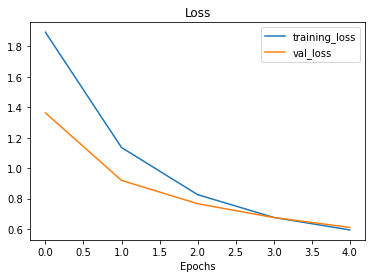

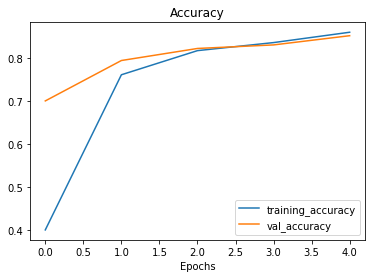

In [ ]:
# Check out our models' training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Let's demonstrate the Global Average Pooling 2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280)

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor :\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor : {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor : (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Let's replicate the GlobalAveragePool2D layers
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

⛏ **Practice:** Try to do the same with the above two cells but this time use `GlobalMaxPool2D`... and see what happens

In [ ]:
input_shape_2 = (1, 4, 4, 3)

tf.random.set_seed(42)
input_tensor_2  = tf.random.normal(input_shape_2)

print(f"Random input tensor :\n {input_tensor_2}")

# Let' check out with GlobalMaxPool2D layer
global_max_pooled_layer = tf.keras.layers.GlobalMaxPooling2D()(input_tensor_2)
print(f"GlobalMaxPoolingLayer : \n {global_max_pooled_layer}")

print(f"Shape of the input tensor : {input_tensor_2.shape}")
print(f"Shape of GlobalMaxPoolingLayer : {global_max_pooled_layer.shape}")

Random input tensor :
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]
GlobalMaxPoolingLayer : 
 [[0.9058464 1.1603122 1.6994323]]
Shape of the input tensor : (1, 4, 4, 3)
Shape of GlobalMaxPoolingLayer : (1, 3)


In [ ]:
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

🔑 **Note:** One of the reasons feature extraction transfer learning is named how it is because what often happens is pretrained model outputs a **feature vector**(a long tensor of numbers which represents the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can them be used to extract patterns out of for our own specific problem.

## Running a series of transfer learning experiments

We've seen the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation.
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation.
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation.

> 🔑 **Note:**  throughtout all experiments the same test dataset will be used to evaluate our model.. this ensures consistency across evaluation metrics.

### Getting and preprocessing data for model_1

In [ ]:
# Download and unzip data-preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2021-07-24 02:18:53--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.188.48, 142.251.45.16, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.188.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   258MB/s    in 0.5s    

2021-07-24 02:18:53 (258 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
# Create training and test dirs
train_dir_1_percent = "drive/MyDrive/10_food_classes_1_percent/train"
test_dir = "drive/MyDrive/10_food_classes_1_percent/test"

In [ ]:
# How many images are we working with?
walk_through_dir("drive/MyDrive/10_food_classes_1_percent")

There are 2 directories and 0 images in 'drive/MyDrive/10_food_classes_1_percent'.
There are 10 directories and 0 images in 'drive/MyDrive/10_food_classes_1_percent/train'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in 'drive/MyDrive/10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7

In [ ]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)



Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing()`

We can see the benefits of doing this within the TensorFlow Data augmentation documentation: https://www.tensorflow.org/tutorials/images/data_augmentation#use_keras_preprocessing_layers.

Off the top our of heads, after reading the docs, the benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than the CPU.
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing


# Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
      preprocessing.RandomFlip("horizontal"),
      preprocessing.RandomRotation(0.2),
      preprocessing.RandomZoom(0.2),
      preprocessing.RandomHeight(0.2),
      preprocessing.RandomWidth(0.2),
      # preprocessing.Rescale(1./255) # Keep for models like ResNet50V2 but EfficientNet's having rescaling built-in 
], name='data_augmentation')

### Visualize our data augmentation layer (and see what happens to our data)

(-0.5, 349.5, 519.5, -0.5)

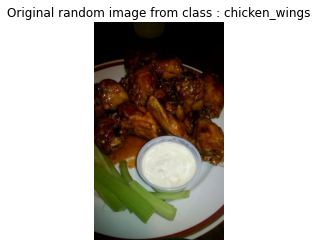

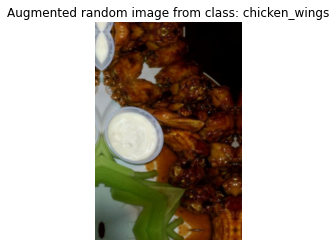

In [ ]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "drive/MyDrive/10_food_classes_1_percent/train/" + target_class
random_image  = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class : {target_class}")
plt.axis(False)

# Now let's plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False)
#print(augmented_img/255.)

## Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable=False

# Create input layer
inputs = layers.Input(shape=input_shape, name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                # Track model training logs
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210723-023527


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 94s 41s/step - loss: 2.4168 - accuracy: 0.0714 - val_loss: 2.2115 - val_accuracy: 0.1497
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1876 - accuracy: 0.1286 - val_loss: 2.1029 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 6s 3s/step - loss: 2.0155 - accuracy: 0.2857 - val_loss: 1.9881 - val_accuracy: 0.3487
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8207 - accuracy: 0.5000 - val_loss: 1.8920 - val_accuracy: 0.4013
Epoch 5/5
3/3 [==============================] - 6s 3s/step - loss: 1.6597 - accuracy: 0.6143 - val_loss: 1.8263 - val_accuracy: 0.4556


In [ ]:
# Check out a model summary
model_1.summary()

In [ ]:
# Evaluate on the full dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

In [ ]:
# How do the model with 1% of the and data augmentation loss curves look?
plot_loss_curves(history_1_percent)


## Model2: Feature extraction transfer learning model with 10% of data and data augmentation

In [21]:
# Get 10% of data

train_dir_10_percent = 'drive/MyDrive/10_food_classes_10_percent/train'
test_dir = 'drive/MyDrive/10_food_classes_10_percent/test'

In [22]:
# Se t data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size =IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [10]:
# create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Build data augmentation layer
data_augmentation = Sequential([
   preprocessing.RandomFlip('horizontal'),
   preprocessing.RandomHeight(0.2),
   preprocessing.RandomWidth(0.2),
   preprocessing.RandomZoom(0.2),
   preprocessing.RandomRotation(0.2),
   # preprocessing.Rescale(1/255.) # if you're using a model such as ResNet50V2, you'll need to rescale your data, efficienet has rescaling built-in.
], name = 'data_augmentation')

# Set up the input shape to our model
input_shape = (224, 224, 3)

# Create a frozen base model (also called the backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable= False

# Create the inputs and outputs (including the layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs) # augment our training images (augmentation doesn't occur on test data)
x = base_model(x, training=False) # pass augmented images to base model but keep it in inference mode, this also insures batchnorm layers don't get updated
x = layers.GlobalAveragePooling2D(name='global_average_pooling_2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs, outputs)

# compile
model_2.compile(loss='categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics=['accuracy'])





16711680/16705208 [==============================] - 0s 0us/step


### Creating a ModelCheckPoint callback

The ModelCheckpoint callback intermediately saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-07-25 02:41:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-25 02:41:18 (62.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback,plot_loss_curves

In [9]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# Create a ModelCheckPoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', #save everty epoch
                                                         verbose=1)

In [24]:
from helper_functions import create_tensorboard_callback

### Fit model 2 passing in the ModelCheckpoint callback


In [25]:
# Fit the model saving checkpoints every epoch
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25 * len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                 experiment_name='10_percent_data_aug'),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210725-033344
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 297s 10s/step - loss: 2.3719 - accuracy: 0.1013 - val_loss: 2.2460 - val_accuracy: 0.2122

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 12s 480ms/step - loss: 2.2505 - accuracy: 0.1787 - val_loss: 2.1257 - val_accuracy: 0.2911

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 15s 593ms/step - loss: 2.1437 - accuracy: 0.2493 - val_loss: 2.0366 - val_accuracy: 0.3240

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 14s 553ms/step - loss: 2.0718 - accuracy: 0.3133 - val_loss: 1.9388 - val_accuracy: 0.4030

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 13s 530ms/step - loss: 1.9847 - accuracy: 0.3627 - val_l

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 354s 4s/step - loss: 0.7082 - accuracy: 0.8012


[0.7082391977310181, 0.8011999726295471]

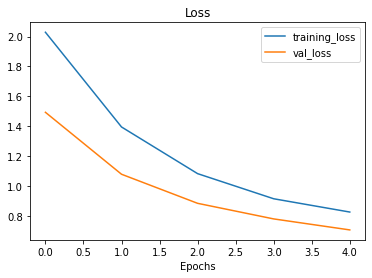

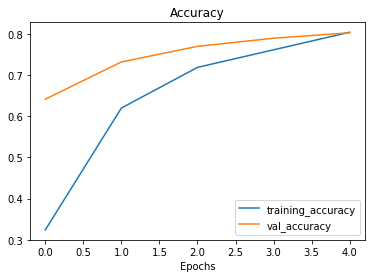

In [ ]:
# Plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in checkpointed weights returns a model to a specific checkpoint

In [ ]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [ ]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 161s 2s/step - loss: 0.7082 - accuracy: 0.8012


In [ ]:
# Check to see if loaded model results are very close to our previous non-loaded model results
# import numpy as np
# np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

NameError: ignored

In [ ]:
# Check the difference between the two results
# print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

## Model 3:Fine-tuning an existing model on 10% of the data.

> 🔑**Note:** Fine-tuning usually works best *after* training a feature extraction model for a few epochs with large amounts of custom data.

In [ ]:
# Layers in loaded model
model_2.layers

In [ ]:
# Are these layers  trainable ?
for layer in model_2.layers:
  print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fe7db5c2ed0> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7fe7db56efd0> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7fe7d5779890> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fe7d57c0d50> True
<tensorflow.python.keras.layers.core.Dense object at 0x7fe7d567a290> True


In [ ]:
# What layers are in our base_model(EfficientNetB0) and are they trainable?
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable) 

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# How many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [ ]:
# To begin fine-tuning, let's start by setting the last 10 layers of our base_model.trainable = True
base_model.trainable = True


# Freeze all layers except for the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),# When fine-tuning you typically want to lower the learning rate by 10X*
                metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


> 🔑 **Note:** When using fine-tuning it's best practice to lower your learning rate by some amount. How much? This is a hyperparameter you can tune. But a good rule of thumb is at least 10x (though different sources will claim other values ).

A good resources for information on this is the ULMFIT paper: https://arxiv.org/abs/1801.06146


In [ ]:
# Check which layers are tunable (trainable)
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [ ]:
# Now we've unfrozen some of the layers closer to the top, how many trainabel variables are there?
print(len(model_2.trainable_variables))

12


In [ ]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_fine_10_percent_dat_aug = model_2.fit(train_data_10_percent,
                                              epochs=fine_tune_epochs,
                                              validation_data = test_data,
                                              validation_steps = int(0.25*len(test_data)),
                                              initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                     experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210725-030454
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 110s 4s/step - loss: 0.7145 - accuracy: 0.7947 - val_loss: 0.5852 - val_accuracy: 0.8092
Epoch 6/10
24/24 [==============================] - 96s 4s/step - loss: 0.5984 - accuracy: 0.8240 - val_loss: 0.5530 - val_accuracy: 0.8141
Epoch 7/10
24/24 [==============================] - 96s 4s/step - loss: 0.5251 - accuracy: 0.8453 - val_loss: 0.5582 - val_accuracy: 0.8125
Epoch 8/10
24/24 [==============================] - 96s 4s/step - loss: 0.4749 - accuracy: 0.8600 - val_loss: 0.5179 - val_accuracy: 0.8224
Epoch 9/10
24/24 [==============================] - 96s 4s/step - loss: 0.4255 - accuracy: 0.8667 - val_loss: 0.5500 - val_accuracy: 0.8207
Epoch 10/10
24/24 [==============================] - 98s 4s/step - loss: 0.3803 - accuracy: 0.8933 - val_loss: 0.5240 - val_accuracy: 0.8289


In [ ]:
# Evaluate the fine-tuned model (model_3 which is actually model_2 fine-tuned for another 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

In [ ]:
# results_10_percent_data_aug

In [ ]:
# Chek out the loss curves of our trained_models
plot_loss_curves(history_fine_10_percent_dat_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however, we want something to compare one series of running `fit()` with another (e.g. before and after fine-tuning)

In [28]:
# Let's create a function to compare training histories
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History objects.
  """

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']
  

  # Combine original history with new_history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']

  total_val_acc = val_acc + new_history.history['val_accuracy']
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plots for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Val Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Traning and Validation Accuracy')


  # Make plots for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Val Loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Traning and Validation Loss')

In [ ]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_dat_aug,
                 initial_epochs=5)

## Model 4 : Fine-tuning and existing model on all data

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-07-25 03:14:08--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-25 03:14:08 (64.8 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import unzip_data

In [ ]:
# Download and unzip 10 classes of Food101 data with all images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data('10_food_classes_all_data.zip')


--2021-07-25 03:14:14--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 2607:f8b0:400e:c09::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   240MB/s    in 2.1s    

2021-07-25 03:14:17 (240 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [ ]:
# Setup training and test dir
train_dir_all_data = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

In [ ]:
from helper_functions import walk_through_dir

# How many images are we working with now?
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 

In [ ]:
# Setup data inputs
import tensorflow as tf
IMAGE_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 image_size=IMAGE_SIZE,
                                                                                 label_mode='categorical')

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMAGE_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


The test dataset we've loaded in is the same as what we've been using for previous experiments (all experiments have used the same test dataset).

Let's verfiy this

In [12]:
# Evaluate model 2 (this is fine-tuned on 10 percent of data version )
# model_2.evaluate(test_data)

To train a fine-tuning model (model_4) we need to revert model_2 back to its feature extraction weights

In [ ]:
# Load weights from checkpoint, that way can fine-tune from
# the same stage the 10 percent data model was fine-tuned from.
# model_2.load_weights(checkpoint_path)

Alright, the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10 % of the data with data augmentation (model_2) and we saved the model the model's weight using ModelCheckpoint callback

2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (model_3)
3. Saved the results and training logs each time.
4. Reloaded the model from step 1 to do the same steps are step 2 except this time we're going to use all of the data (model_4).

In [13]:
# Check which layer are tunable in the whole model
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 False
3 global_average_pooling_2D True
4 output_layer True


In [17]:
# Let's drill into our base_model(efficientnetb0) and see what layers are trainable
# for layer_number, layer in enumerate(model_2.layers[2].layers):
#   print(layer_number, layer.name, layer.trainable )

In [18]:
# Compile
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [26]:
# Contine to train and fine-tune the model to our data (100% of training data)
fine_tune_epochs = initial_epochs + 5
history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25 * len(test_data)),
                                           initial_epoch = history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='full_10_classes_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210725-034010
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 69s 292ms/step - loss: 1.6950 - accuracy: 0.5200 - val_loss: 1.2611 - val_accuracy: 0.7204
Epoch 6/10
235/235 [==============================] - 62s 261ms/step - loss: 1.3239 - accuracy: 0.6593 - val_loss: 0.9733 - val_accuracy: 0.7796
Epoch 7/10
235/235 [==============================] - 56s 236ms/step - loss: 1.1248 - accuracy: 0.7039 - val_loss: 0.8125 - val_accuracy: 0.7993
Epoch 8/10
235/235 [==============================] - 53s 224ms/step - loss: 1.0017 - accuracy: 0.7313 - val_loss: 0.7146 - val_accuracy: 0.8109
Epoch 9/10
235/235 [==============================] - 49s 209ms/step - loss: 0.9232 - accuracy: 0.7424 - val_loss: 0.6370 - val_accuracy: 0.8273
Epoch 10/10
235/235 [==============================] - 46s 195ms/step - loss: 0.8685 - accuracy: 0.7488 - val_loss: 0.6099 - val_accuracy: 0.8257


In [27]:
# Let's evaluate on test data 
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 250s 3s/step - loss: 0.6129 - accuracy: 0.8364


[0.6128849387168884, 0.8363999724388123]

In [30]:
import matplotlib.pyplot as plt

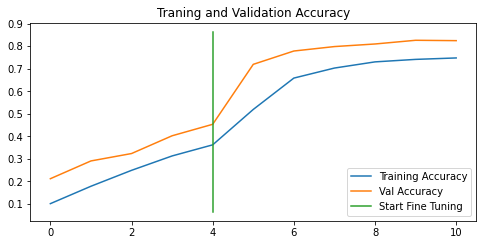

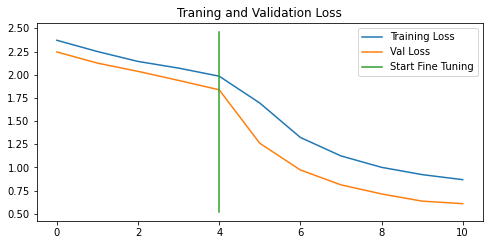

In [31]:
compare_historys(history_10_percent_data_aug, history_fine_10_classes_full)